In [1]:
import wandb
import json
import pandas as pd
import glob
import matplotlib
from matplotlib import pyplot as plt



In [2]:
def get_eval_data(project, tag, filename):
    dfs = []
    for r in wandb.Api().runs(project, filters=dict(tags=tag)):
        if tag in r.tags:
            cfg = json.loads(r.json_config)
            for f in r.files():
                if glob.fnmatch.fnmatch(f.name, filename):
                    print("loading", f.name, "from", r.name)
                    root = "/tmp"
                    f.download(root, replace=True)
                    path = f"{root}/{f.name}"
                    eval_data = json.loads(open(path).read())

                    df = pd.DataFrame(eval_data)
                    df["acquire_pairs_function"] = cfg["exp5"]["value"]["acquire_pairs_function"]
                    #df["og"] = int(cfg["exp5"]["value"]["over_generate_factor"])
                    df["seed"] = int(cfg["seed"]["value"])
                    df["run_name"] = r.name
                    df["i_phase"] = int(f.name.split("_")[2].replace("phase", ""))
                    dfs.append(df)
    
    return pd.concat(dfs)


In [3]:
df = get_eval_data("wm-debug-imdb", "dap1", "evaluation_m64_phase*_post_training_T0.25.json")

loading evaluation_m64_phase0_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase100_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase10_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase110_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase120_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase130_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase140_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase150_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase160_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase170_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase180_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase190_post_training_T0.25.json from dutiful-shape-228
loading evaluation_m64_phase20_post_trainin

In [4]:
df["win"] = df["vs_wins"]

<AxesSubplot: xlabel='i_phase'>

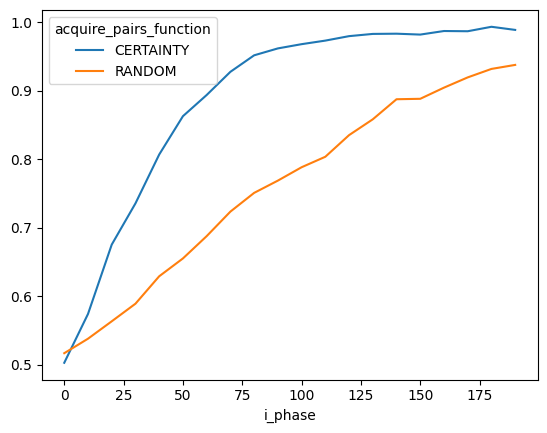

In [5]:
df.groupby(["i_phase", "acquire_pairs_function"]).vs_wins.mean().unstack().plot()

In [6]:
def analyse(df, title=None, noreset=False):
    
    mean_win = df.groupby(["acquire_pairs_function", "i_phase"]).win.mean().unstack()
    std = df.groupby(["acquire_pairs_function", "i_phase", "seed"]).win.mean().groupby(["acquire_pairs_function", "i_phase"]).std().unstack()
    n = df.groupby(["acquire_pairs_function", "i_phase", "seed"]).win.mean().groupby(["acquire_pairs_function", "i_phase"]).count().unstack()
    c = df.groupby(["acquire_pairs_function", "i_phase"]).win.count().unstack() / n
    stderr = std / (n**0.5)

    if title is not None:
        print("=========================================")
        print(f" {title}") 
        print("=========================================")
    
    print("============= WIN RATE ============")
    display(mean_win)
    print("============= STD ERR ============")
    display(stderr)
    print("============= NUM SEEDS ============")
    display(n)
    print("============= EVAL DATAPOINTS PER SEED ============")
    display(c)
    
    colors = matplotlib.colormaps["Set1"]
    fig, ax = plt.subplots(figsize=(10, 8))
    
    mean_win_per_seed = df.groupby(["acquire_pairs_function", "i_phase", "seed"]).win.mean().reset_index()
    
    for i, apf in enumerate(sorted(set(df["acquire_pairs_function"]))):
        data = mean_win_per_seed[mean_win_per_seed.acquire_pairs_function == apf]
        ax.scatter(data["i_phase"], data["win"], color=colors(i), marker="x", alpha=0.5, s=8)
        line_data = pd.DataFrame(data.groupby("i_phase").win.mean())
        line_data["std"] = data.groupby("i_phase").win.std()
        line_data["stderr"] = line_data["std"] / data.groupby("i_phase").win.count()**0.5 
        line_data = line_data.reset_index()
            
        ax.errorbar(line_data["i_phase"], line_data["win"], yerr=line_data["stderr"], capsize=5, c=colors(i), label=apf)
        #display(line_data)
    
    ax.legend();


 IMDB - Single epoch between data acquisition phases with no reset. 
 Eval vs ref model using distilbert sentiment model. beta=0.2, lr=1e-6, Adam
 CERTAINTY overgenerate factor=8

============= WIN RATE ============


i_phase,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190
acquire_pairs_function,,,,,,,,,,,,,,,,,,,,
CERTAINTY,0.502930,0.574219,0.675456,0.735677,0.806966,0.862956,0.893880,0.927734,0.951823,0.961914,0.968099,0.973307,0.979818,0.983073,0.983398,0.982096,0.987305,0.986979,0.993490,0.988932
RANDOM,0.516927,0.538086,0.563477,0.589193,0.629232,0.655273,0.687826,0.723633,0.750977,0.768880,0.788411,0.803711,0.835286,0.858398,0.887695,0.888346,0.904622,0.919596,0.931966,0.937826


============= STD ERR ============


i_phase,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190
acquire_pairs_function,,,,,,,,,,,,,,,,,,,,
CERTAINTY,0.007373,0.010889,0.009167,0.009706,0.000861,0.012984,0.001722,0.008132,0.007337,0.000977,0.000861,0.002781,0.001812,0.002135,0.002255,0.001812,0.002255,0.000651,0.001302,0.001628
RANDOM,0.006727,0.012404,0.007627,0.007050,0.012097,0.007893,0.002893,0.007373,0.014397,0.003668,0.003754,0.005167,0.008369,0.004066,0.003139,0.004795,0.007696,0.001980,0.004000,0.007444


============= NUM SEEDS ============


i_phase,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190
acquire_pairs_function,,,,,,,,,,,,,,,,,,,,
CERTAINTY,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
RANDOM,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


============= EVAL DATAPOINTS PER SEED ============


i_phase,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190
acquire_pairs_function,,,,,,,,,,,,,,,,,,,,
CERTAINTY,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0
RANDOM,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0,1024.0


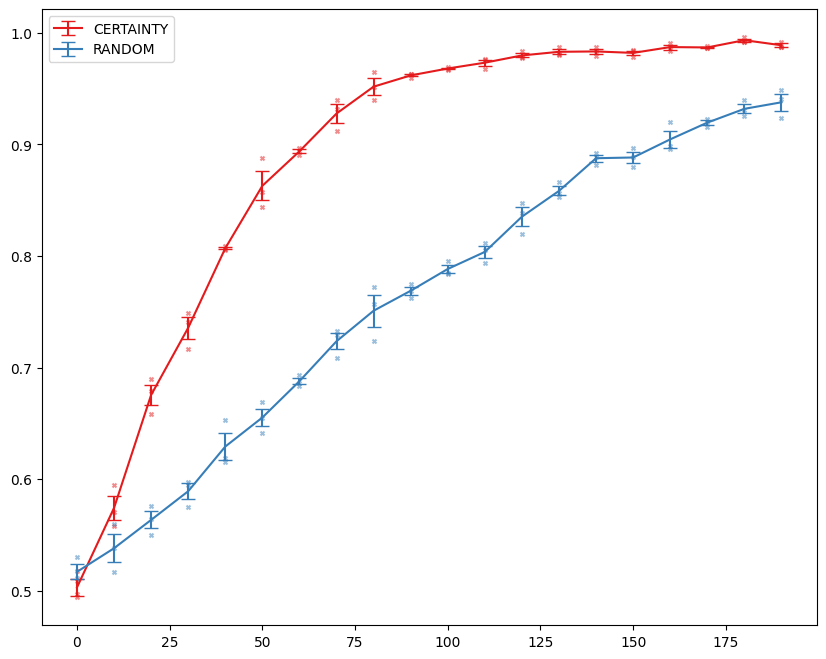

In [13]:
# e.g. https://wandb.ai/bbnn/wm-debug-imdb/runs/h07nk76e
analyse(df, title="""IMDB - Single epoch between data acquisition phases with no reset. 
 Eval vs ref model using distilbert sentiment model. beta=0.2, lr=1e-6, Adam
 CERTAINTY overgenerate factor=8
""")